In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dem_stitcher.stitcher import download_dem
import rasterio
import matplotlib.pyplot as plt
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
from pathlib import Path
from dem_stitcher.rio_tools import crop_profile_from_coord_bounds
from dem_stitcher.stitcher import merge_tiles
from rasterio import default_gtiff_profile
import numpy as np

In [3]:
site = 'bay_area' # 'bay_area' or 'aleutian'
dem_0 = 'srtm_v3' # 'ned1' #'tdx_30'
dem_1 = 'nasadem' # 'ned1'
save_raw_tiles = True

In [4]:
if site == 'bay_area':
    bounds = [-121.5, 34.95, -120.2, 36.25]
elif site == 'aleutian':
    bounds = [-170, 51, -160, 56]
else:
    raise ValueError('Site not valid')

# dem_0

In [5]:
%%time

out_path_0 = download_dem(bounds, 
                          dem_0, 
                          f'sample_{dem_0}_{site}',
                          save_raw_tiles=save_raw_tiles,
                          # More than 5 workers can cause timeout errors.
                          max_workers=5)
out_path_0

CPU times: user 3.85 s, sys: 1.82 s, total: 5.67 s
Wall time: 16.5 s


'srtm_v3.dem.wgs84'

BoundingBox(left=-121.50041666666667, bottom=34.94986111111111, right=-120.1998611111111, top=36.250416666666666)


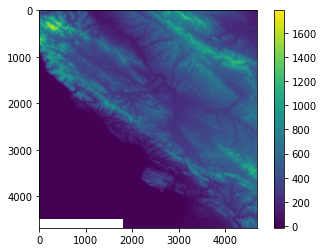

In [6]:
with rasterio.open(out_path_0) as ds:
    print(ds.bounds)
    X_0 = ds.read(1)
    p_0 = ds.profile
    
plt.imshow(X_0)
plt.colorbar()

In [7]:
p_0

{'driver': 'ISCE', 'dtype': 'float32', 'nodata': nan, 'width': 4682, 'height': 4682, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -121.50041666666667,
       0.0, -0.0002777777777777778, 36.250416666666666), 'tiled': False}

# dem_1

In [8]:
%%time

out_path_1 = download_dem(bounds, 
                          dem_1, 
                          f'sample_{dem_1}_{site}',
                          save_raw_tiles=save_raw_tiles,
                          max_workers=5)
out_path_1

CPU times: user 3.85 s, sys: 1.71 s, total: 5.55 s
Wall time: 16.8 s


'nasadem.dem.wgs84'

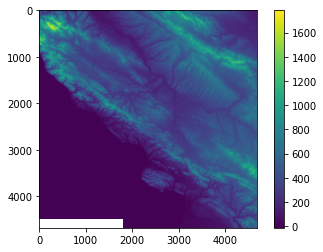

In [9]:
with rasterio.open(out_path_1) as ds:
    X_1 = ds.read(1)
    p_1 = ds.profile
    
plt.imshow(X_1)
plt.colorbar()

In [10]:
p_1

{'driver': 'ISCE', 'dtype': 'float32', 'nodata': nan, 'width': 4682, 'height': 4682, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -121.50041666666667,
       0.0, -0.0002777777777777778, 36.250416666666666), 'tiled': False}

# Comparison

In [11]:
X_1_r, _ = reproject_arr_to_match_profile(X_1, p_1, p_0)
X_1_r = X_1_r[0, ...]

Text(0.5, 0, 'nasadem - srtm_v3 (m)')

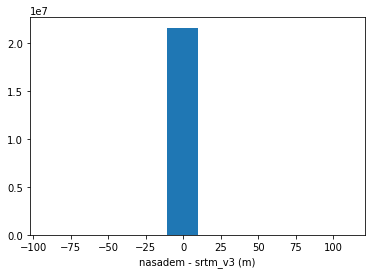

In [12]:
diff = (X_1_r - X_0)
diff_r = diff[~np.isnan(diff)]
plt.hist(diff_r)
plt.xlabel(f'{dem_1} - {dem_0} (m)')

In [13]:
import scipy.stats as stats
import numpy as np

diff_r_ = diff_r.copy()
T = .5

diff_r_ = diff_r_[np.abs(diff_r_) < T]
percent_small = np.sum((np.abs(diff_r_) < T)) / len(diff_r)
print(f'Percent less than {T*100} cm: ', percent_small)
print('these are the stats of the differences')
stats.describe(diff_r_)

Percent less than 50.0 cm:  0.5113907333102954
these are the stats of the differences


DescribeResult(nobs=11042635, minmax=(-1.0186341e-10, 7.858034e-10), mean=7.578632e-15, variance=1.2517768e-24, skewness=231.6967010498047, kurtosis=78694.26717857973)

In [14]:
stats.describe(diff_r[~np.isnan(diff_r)])

DescribeResult(nobs=21593342, minmax=(-92.0, 111.0), mean=-0.058560226, variance=1.3828285, skewness=0.2063475102186203, kurtosis=62.40585435951078)

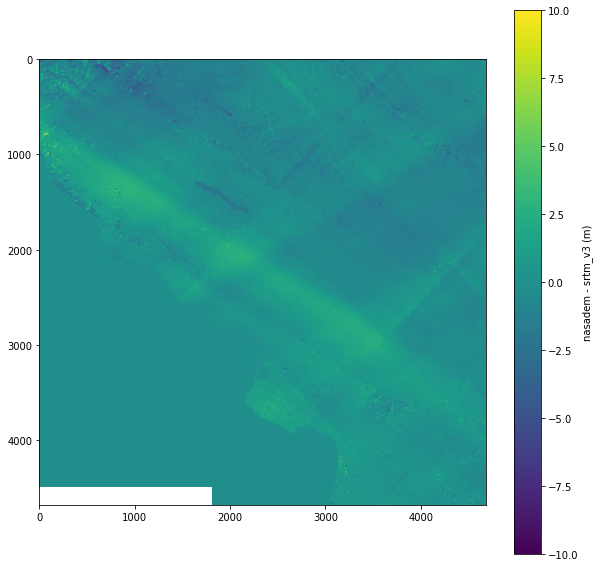

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(diff, vmin=-10, vmax=10)
plt.colorbar(label=f'{dem_1} - {dem_0} (m)')